# Neural Network Binary:
A basic implementation of the sampled binary Neural Network with Explainability which includes:
- Encoding categorical features with the encoder classes.
- Viewing the distribution of majority labels using a visualiser.
- Preprocessing data for a Neural Network.
- Preproccing data for a Binary Tree Model.
- Optimising the Neural Network and saving it to a folder.
- Loading a saved Neural Network from the given path.
- Evaluating Training and Test set results.
- Running a secondary Tree Model to reduce false positives.
- Integrating the results into shap using the Shap Manager Class.

In [1]:
# Check the working directory and set it to the main folder if needed.
# Set the directory to the main directory for imports.
import os
os.getcwd()

'c:\\Users\\adi_s\\Desktop\\LSTM\\UserGuides'

In [2]:
# Changing to main directory for Module imports.
os.chdir('../')

Imports and Dependencies. Most modules will be loaded as they are needed for explainability.

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch

We load a given dataset that should be placed in the Data folder in UserGuide. For this we will use the current data. This is a binary classification example so the dataset used should be binary.

In [4]:
# Preprocess.
data = pd.read_csv('UserGuides/Data/Cleaned_full_data.csv')
# Reset retained index.
data = data.reset_index(drop=True)
# A little bit of extra cleaning.
data['ct_ftp_cmd'] = data['ct_ftp_cmd'].fillna(0)
data['attack_cat'] = data['attack_cat'].str.replace(r'\s+', '', regex=True)
data['attack_cat'] = data['attack_cat'].str.replace('Backdoors', 'Backdoor')

C:\Users\adi_s\AppData\Local\Temp\ipykernel_12192\62178567.py:2: DtypeWarning: Columns (1,3) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('UserGuides/Data/Cleaned_full_data.csv')


For the purpose of simplifying the the example we use a smaller sample.

In [5]:
data = data.sample(n=100000)
# Need to reset the index otherwise we can get Nulls.
data = data.reset_index(drop=True)

Now we find our categorical features. Here we want to make sure we don't include any features that are actually labels. In this case its 'attack_cat'.
Keep in mind that at times they may be of type 'category' instead where we would use 'category' instead of 'object' as a dtype.

In [6]:
categories = data.select_dtypes(include='object').columns.tolist()
print(categories)
# We remove attack_cat from the list:
if 'attack_cat' in categories:
    categories.remove('attack_cat')
print(categories)

['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'service', 'attack_cat']
['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'service']


Because the Neural Network requires categories to be one-hot encoded we use the correlation one-hot encoder to get the most relevant features based on certain thresholds. Since we have a binary classification label this becomes particularly useful. The procedure goes through each value inside a categorical feature and converts it to a binary. Then it calculates the correlation for two binaries (Phi coefficient) between it and the label which in this case is the threat label. The encoder also helps to deal with memory allocation issues. If we were to to one-hot encode all the values, we will get an error as we would have an array of more than approximately 5,750,000,000 values. It also spares us the effort drawing the correlation seperately and inputing it into the OneHotEncoder class as it is all automatic.

In [7]:
# Import the correlation encoder.
from Tools.encoders import CorrOnehotEncoder
# Print the docstring.
help(CorrOnehotEncoder)

Help on class CorrOnehotEncoder in module Tools.encoders:

class CorrOnehotEncoder(builtins.object)
 |  CorrOnehotEncoder(column, target)
 |
 |  CorrOnehotEncoder: Encodes the given column by creating one-hot encoded columns for categories that have
 |  a correlation higher than a threshold with the target column.
 |
 |  Methods defined here:
 |
 |  __init__(self, column, target)
 |      Parameters:
 |          - column (pd.Series) The feature column to encode.
 |          - target (pd.Series) The target column.
 |
 |  corr(self, x, y)
 |      Calculate the Pearson correlation coefficient (Phi).
 |
 |      Parameters:
 |          - x (tensor - float32) The first variable.
 |          - y (tensor - float32) The target to draw correlation to.
 |
 |      Returns:
 |          - r (float32) The Pearson correlation coefficient (Phi).
 |
 |  encode(self, sparse_n, threshold, max_encoded)
 |      Encode the feature column by creating one-hot encoded columns for categories that have
 |      a c

In [8]:
# Parameters:
# The minimum number of 1's in the value (deals with sparse data). Since we are using sample data of 100, 000 we keep this pretty low. This parameter also significantly
# impacts the time to encode data. The higher the sparse_n value, the less values are calculated. However having a high value could potentially lead to worse accuracy.
sparse_n = 600
# The threshold for correlation. 0 means the binary must have atleast some correlation. Correlation is collected for positive and negative instances. Ideally you we want this
# to be as close to 0 as possible as it will collect as many relevant features as possible for the evaluation phase (when we want to see how features interact with threats). 
# For example purposes we increase it to 0.1. A good check to do is to see how many unique values exist in the categorical variable before putting it through.
threshold = 0.1
# The limit for the encoded features. After collecting correlation the highest correlated values are sorted (highest to lowest) and the maximum is selected.
max_encoded = 30
ce = CorrOnehotEncoder(data['srcip'], data['label'])
ohe1 = ce.encode(sparse_n, threshold, max_encoded)
ce = CorrOnehotEncoder(data['sport'], data['label'])
ohe2= ce.encode(sparse_n, threshold, max_encoded)
ce = CorrOnehotEncoder(data['dstip'], data['label'])
ohe3 = ce.encode(sparse_n, threshold, max_encoded)
ce = CorrOnehotEncoder(data['dsport'], data['label'])
ohe4 = ce.encode(sparse_n, threshold, max_encoded)
ce = CorrOnehotEncoder(data['proto'], data['label'])
ohe5 = ce.encode(sparse_n, threshold, max_encoded)
ce = CorrOnehotEncoder(data['state'], data['label'])
ohe6 = ce.encode(sparse_n, threshold, max_encoded)
ce = CorrOnehotEncoder(data['service'], data['label'])
ohe7 = ce.encode(sparse_n, threshold, max_encoded)

Before adding the data back in lets take a quick look at what the data looks like for Normal labels (the majority label). We can evaluate how noisy the data is in the label based on different scalers. The cluster visualiser is limited to looking at continous data so will need to filter out binaries and discreet variables with small amounts of unique values.

In [9]:
# Create a new dataset with just Normal labels and make sure to drop the categorical columns from before.
cluster_data = data.drop(columns=categories)
# Now we set it to just Normal labels.
cluster_data = cluster_data[cluster_data['attack_cat'] == 'Normal']

In [10]:
# Now we try and filter for mostly continuous variables.
# Collect variables.
remove = []
for i in cluster_data:
    if len(cluster_data[i].unique()) < 30:
        remove.append(i)
# Drop the varibles collected.
cluster_data = cluster_data.drop(columns=remove)

In [11]:
# Import the cluster visualiser and read doc.
from Tools.cluster_visualiser import PlotClusters
# Read the docs.
help(PlotClusters)

Help on class PlotClusters in module Tools.cluster_visualiser:

class PlotClusters(builtins.object)
 |  PlotClusters(data, scaler_type, sample_size)
 |
 |  PlotClusters: A class that plots different clusters in a 3-D plot with augmentations. Easily evaluate K-means++ clusters or use DBSCAN to seperate noise from other clusters.
 |  Use either just the normal Kmeans++ to 3D or DBSCAN to 3D or optionally project it through TSNE. Makes it easy to quickly visualise within label groups.
 |
 |  Methods defined here:
 |
 |  __init__(self, data, scaler_type, sample_size)
 |      Parameters:
 |          - data (pd.DataFrame) The Dataset to analyse which should have the labels filtered out.
 |          - scaler_type (string) Either use 'standard' or 'minmax' scaler.
 |          - sample_size (int) Sample a smaller size - increasing this to above 10000 significantly increasing computation for TSNE.
 |
 |  plot_dbscan(self, eps=0.5, min_samples=20)
 |      plot_tsne:  DBSCAN clustering and visuali

We will use TSNE so we do not have to reduce our data using PCA. This will allow us to visualise more points. The problem with 2D planes and PCA is that we lose explainability based on the cumulative percentage of PCA components. TSNE does a much better job at capturing the data. We combine this with DBScan which helps us to plot the noise in the data as red dots. Lets check what the data looks like when we use Standard Scaling and Min Max Scaling.

Standard Scaler

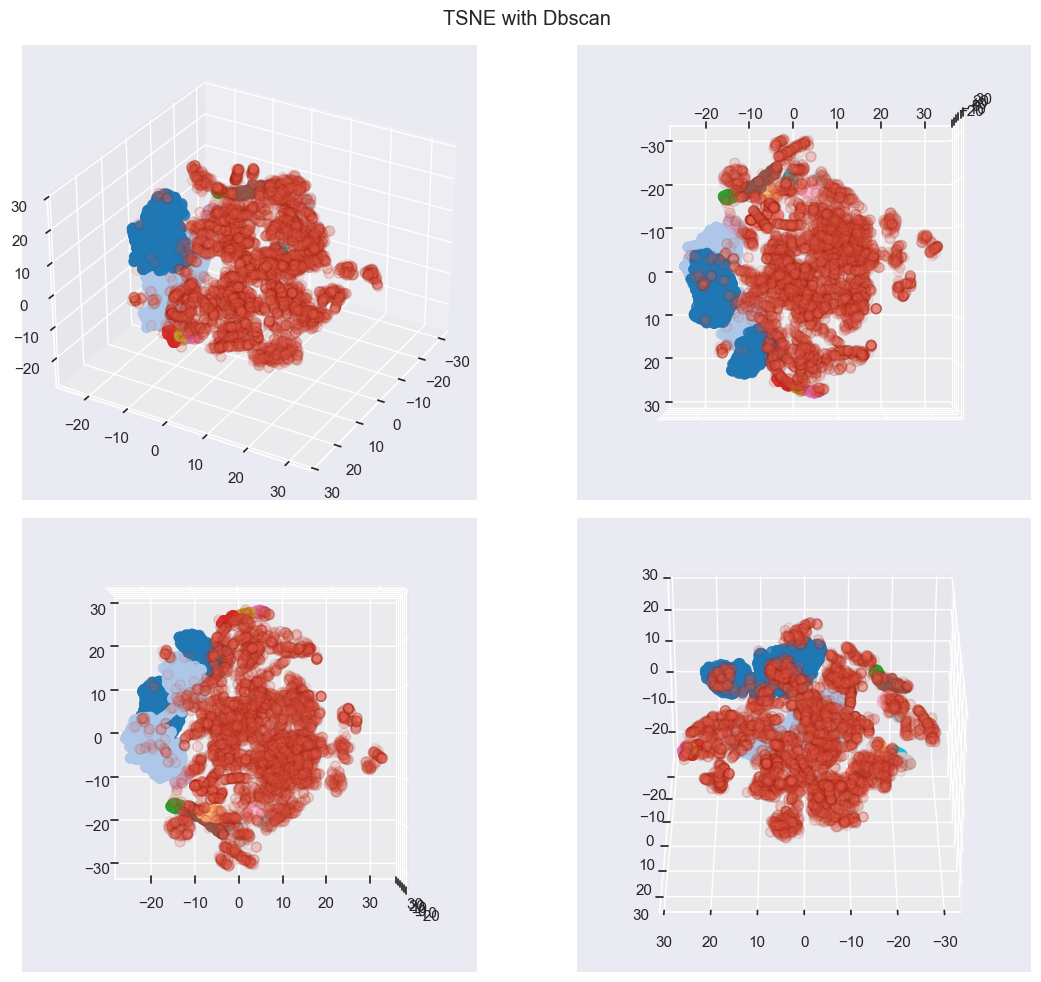

In [12]:
# Check Standard scaling data.
scaler = 'standard'
# Select the same size as all the currently sampled data. A limit of 10000 is recommended as TSNE is computationally expensive.
sample_size = 10000
pc = PlotClusters(cluster_data, scaler, sample_size)
# Ommit PCA conversion.
apply_pca = False
# DBSCAN doesnt use clusters.
n_clusters = None
# Learning rate for TSNE - this sometimes impacts the shape we get in the plots. We will set it to automatic.
learning_rate = 'auto'
# The perplexity directly affects the shape output of TSNE. Can at sometimes be pretty random but 30 usually works quite well. As we increase it towards 100 we get more stringy
# type results.
perplexity=30
# Select DBScan type clusters.
cluster_type = 'dbscan'
# Epsilon is the threshold for noise. It decides the ring (epsilon) at which to classify the points as noise or not.
epsilon = 0.5
pc.plot_tsne(apply_pca, n_clusters, learning_rate, perplexity, cluster_type, epsilon)

Now Lets Check Min-Max Scaling.

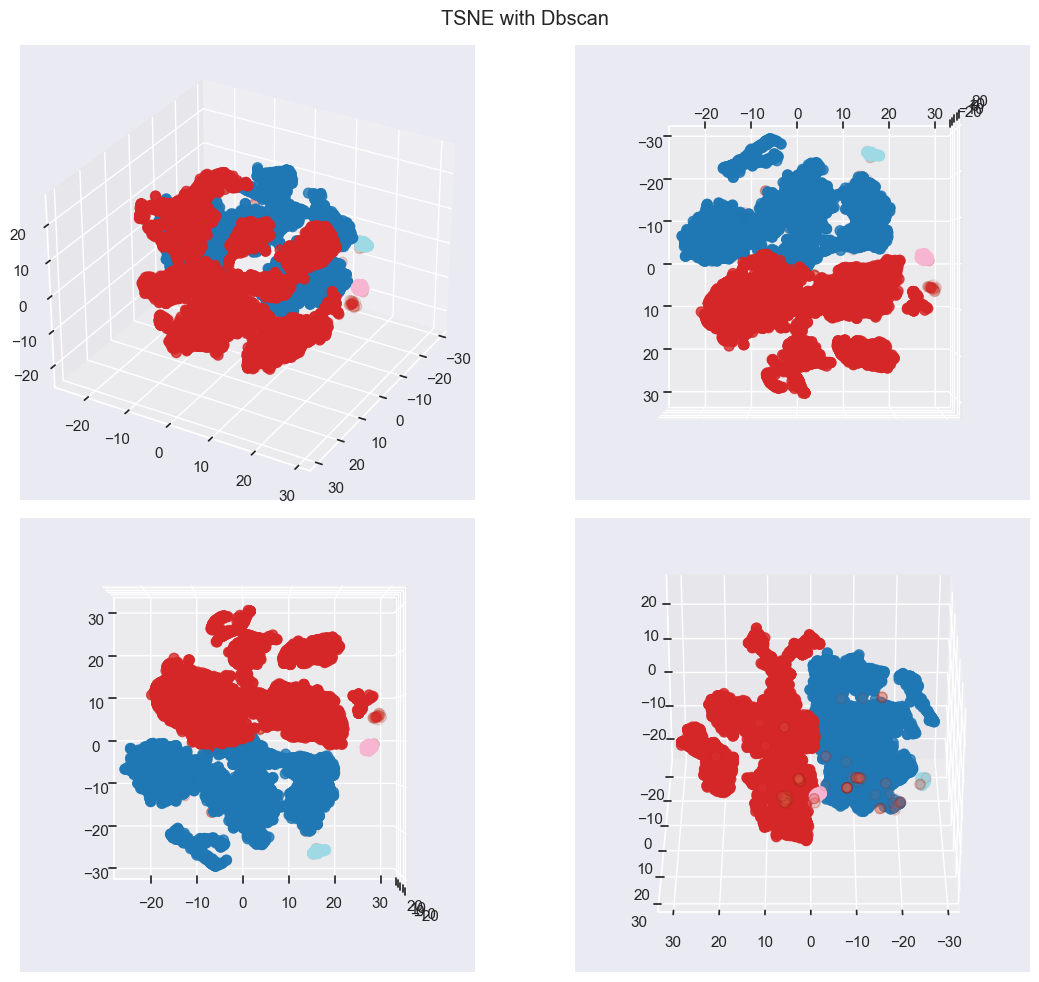

In [13]:
# Check Min-Max scaling data.
scaler = 'minmax'
# Select the same size as all the currently sampled data. A limit of 10000 is recommended as TSNE is computationally expensive.
sample_size = 10000
pc = PlotClusters(cluster_data, scaler, sample_size)
# Ommit PCA conversion.
apply_pca = False
# DBSCAN doesnt use clusters.
n_clusters = None
# Learning rate for TSNE - this sometimes impacts the shape we get in the plots. We will set it to automatic.
learning_rate = 'auto'
# The perplexity directly affects the shape output of TSNE. Can at sometimes be pretty random but 30 usually works quite well. As we increase it towards 100 we get more stringy
# type results.
perplexity=30
# Select DBScan type clusters.
cluster_type = 'dbscan'
# Epsilon is the threshold for noise. It decides the ring (epsilon) at which to classify the points as noise or not.
epsilon = 0.5
pc.plot_tsne(apply_pca, n_clusters, learning_rate, perplexity, cluster_type, epsilon)

Scaling data is effective for Neural Networks. It helps to reduce the overload of large distances between points. However this comes at a cost. Once the data is scaled the distance is lost meaning that the variables can only be described as being higher or lower with respect to themselves rather than real points in space. We see that noise is presumably reduced in Normal labels when using min-max scaling based on the same epsilon and will go forward as using that as our scaler in the Neural Network. Now lets continue pre-processing the data by scaling it and recombining the encoded features.

In [14]:
# Drop the one-hot encoded features from the actual dataset.
data = data.drop(columns=['proto', 'dsport', 'service', 'state', 'srcip', 'sport', 'dstip'])
# We put binaries and labels (label, attack_cat) in a temp DataFrame and scale all other variables.
temp = data[['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat']]
data = data.drop(columns=['is_ftp_login', 'is_sm_ips_ports', 'label', 'attack_cat'])

In [15]:
# Now scale the data using min-max scaler.
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

In [16]:
# Recombine all the datasets.
# First we need to create the scaled_data into a DataFrame as I think it returns a numpy array.
data = pd.DataFrame(scaled_data, columns=data.columns)
# Then recombine the data.
data = pd.concat([data, temp, ohe1, ohe2, ohe3, ohe4, ohe5, ohe6, ohe7], axis=1)

Now we process the data further by splitting it into a training and test set. Generally for Neural Networks we would use a validation set. But in this case we are ommiting it.

In [17]:
# First remove the labels in the actual data.
X_temp = data.drop(columns=['label', 'attack_cat'])
# Set y1 as the binary label.
y1 = data['label']
# Split the data into 80% train and 20% test.
X_train, X_test, y_train, y_test = train_test_split(
    X_temp, y1, test_size=0.2, random_state=42)

DataLoader objects and Neural Networks through the torch framework require tensors so the data needs to be converted further. The Dataloader object allows for the data to be fed into the network in batches. If we select a batch size of 128 that means the training and test data are split into 128 pieces and fed in one after the other.

In [18]:
# Select the batch size. This directly impacts the effectiveness of some sampling methods.
batch_size = 128
# Convert each train and test set into tensors.
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)
# Convert to a Tensor Dataset which stores both the train and test sets.
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
# Add the Tensor Datasets into a DataLoader object which manages the batching. Shuffle function is used on the train set but not the test set.
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Import and Set Up the Neural Network. Lets use SMOTE upsampling technique. SMOTE takes the minority labels in the batch (in this case threats) and upsamples them to the majority labels. This means for each batch if there is 20 Threat labels and 100 Normal, SMOTE will synthetically create 80 more threat labels and make them equal (100, 100). This is useful when the minority class is much lower because it becomes hard to predict and usually we get an imbalance where we get a high accuracy on majority labels but low accuracy on minority labels. By using SMOTE we balance this out and usually get the reverse where we significantly increase minority label (threat) predictions at the cost of incorrectly predicting some majority labels (Normal).

In [19]:
# Import the Neural Network and supporting functions.
from Models.models import NNdynamic, plot_metrics, plot_confusion_matrix
# read the Neural Network docs.
help(NNdynamic)

Help on class NNdynamic in module Models.models:

class NNdynamic(torch.nn.modules.module.Module)
 |  NNdynamic(n_features, fc_size, device, save_dir)
 |
 |  NNdynamic: A dynamic Neural Network which can implement different sampling techniques from imb-learn in the training pass to handle imbalanced classes. Alternatively,
 |  use the standard NN model.The process selects a sampler and implements it within the batches. The batch size influences the potential for sample to fail where it defaults
 |  back to a normal sample. In general large batch sizes tend to result in less errors.
 |
 |  Initialisation:
 |      - n_features (int) The number of features used in the data.
 |      - fc_size (int) The size of the dense layer which directly impacts complexity into shap calculations (weights | parameters).
 |      - device (torch.device) The device to calculate the tensor processes (currently only tested with cpu).
 |      - save_dir (string) The path to save the NN object. Saves using the 

In [20]:
# We can normally run tensors on the GPU but are still getting potential errors so will force it to a cpu for this example.
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")
# The number of features which we have in the dataset.
n_features = X_train_tensor.shape[1]
# The dense layer size. This is the complexity of the dense (fully connected) layer. This is a type of communication between the arrays where each column (feature)
# communicates with every other column. In general the Neural Network has this kind of layer expansion, runs an activation function, then contracts it down to the number
# of labels we want to predict which in this case is 2.
fc_size = 128
# This is the directory to save to. Create a Test folder in the Models/saved_models folder. Make sure to add the ./ - for some reason I get errors otherwise.
save_dir = './Models/saved_models/Test'
# Create the model with the input parameters.
model = NNdynamic(n_features, fc_size, device, save_dir)
# Set the sampler to 'smote'
sampler = 'smote'
# Set the sampling strategy to 'auto'. Since it is binary it will focus on sampling the minority class up to the majority class.
params = {'sampling_strategy': 'auto'}
# We will decrease the learning rate so we can create some visuals that show how the model trains over each epoch. The lower the learning rate, the less likely we are
# going to overshoot the minimum. However the lowest loss might not be always desirable when using sampling methods such as SMOTE and focusing on threats.
learning_rate = 0.01
# The number of loops over the whole dataset.
epochs = 20
# The save factor we can save the Model for each epoch then reload the best performing one after.
save_factor = 1
# Now run the model.
model.run(train_loader, learning_rate, epochs, save_factor, sampler, params, store_data=True)

Epoch 1/20: 100%|██████████| 625/625 [00:11<00:00, 55.70batch/s]


Epoch [1/20], Train Loss: 0.0337, Train Acc: 0.9874, Train F1: 0.9868


Epoch 2/20: 100%|██████████| 625/625 [00:10<00:00, 57.03batch/s]


Epoch [2/20], Train Loss: 0.0225, Train Acc: 0.9920, Train F1: 0.9920


Epoch 3/20: 100%|██████████| 625/625 [00:10<00:00, 57.25batch/s]


Epoch [3/20], Train Loss: 0.0201, Train Acc: 0.9924, Train F1: 0.9924


Epoch 4/20: 100%|██████████| 625/625 [00:10<00:00, 57.00batch/s]


Epoch [4/20], Train Loss: 0.0201, Train Acc: 0.9921, Train F1: 0.9921


Epoch 5/20: 100%|██████████| 625/625 [00:11<00:00, 56.70batch/s]


Epoch [5/20], Train Loss: 0.0184, Train Acc: 0.9923, Train F1: 0.9923


Epoch 6/20: 100%|██████████| 625/625 [00:11<00:00, 55.95batch/s]


Epoch [6/20], Train Loss: 0.0174, Train Acc: 0.9928, Train F1: 0.9928


Epoch 7/20: 100%|██████████| 625/625 [00:11<00:00, 56.63batch/s]


Epoch [7/20], Train Loss: 0.0170, Train Acc: 0.9930, Train F1: 0.9930


Epoch 8/20: 100%|██████████| 625/625 [00:11<00:00, 56.48batch/s]


Epoch [8/20], Train Loss: 0.0162, Train Acc: 0.9931, Train F1: 0.9931


Epoch 9/20: 100%|██████████| 625/625 [00:10<00:00, 57.56batch/s]


Epoch [9/20], Train Loss: 0.0154, Train Acc: 0.9936, Train F1: 0.9936


Epoch 10/20: 100%|██████████| 625/625 [00:09<00:00, 66.99batch/s]


Epoch [10/20], Train Loss: 0.0156, Train Acc: 0.9934, Train F1: 0.9934


Epoch 11/20: 100%|██████████| 625/625 [00:10<00:00, 60.15batch/s]


Epoch [11/20], Train Loss: 0.0148, Train Acc: 0.9935, Train F1: 0.9935


Epoch 12/20: 100%|██████████| 625/625 [00:11<00:00, 55.87batch/s]


Epoch [12/20], Train Loss: 0.0149, Train Acc: 0.9932, Train F1: 0.9932


Epoch 13/20: 100%|██████████| 625/625 [00:11<00:00, 56.18batch/s]


Epoch [13/20], Train Loss: 0.0141, Train Acc: 0.9939, Train F1: 0.9939


Epoch 14/20: 100%|██████████| 625/625 [00:10<00:00, 56.86batch/s]


Epoch [14/20], Train Loss: 0.0135, Train Acc: 0.9938, Train F1: 0.9938


Epoch 15/20: 100%|██████████| 625/625 [00:10<00:00, 57.29batch/s]


Epoch [15/20], Train Loss: 0.0139, Train Acc: 0.9937, Train F1: 0.9937


Epoch 16/20: 100%|██████████| 625/625 [00:11<00:00, 55.91batch/s]


Epoch [16/20], Train Loss: 0.0129, Train Acc: 0.9941, Train F1: 0.9941


Epoch 17/20: 100%|██████████| 625/625 [00:08<00:00, 73.43batch/s]


Epoch [17/20], Train Loss: 0.0140, Train Acc: 0.9937, Train F1: 0.9937


Epoch 18/20: 100%|██████████| 625/625 [00:08<00:00, 73.87batch/s]


Epoch [18/20], Train Loss: 0.0139, Train Acc: 0.9937, Train F1: 0.9937


Epoch 19/20: 100%|██████████| 625/625 [00:08<00:00, 78.12batch/s]


Epoch [19/20], Train Loss: 0.0128, Train Acc: 0.9943, Train F1: 0.9943


Epoch 20/20: 100%|██████████| 625/625 [00:08<00:00, 77.56batch/s]

Epoch [20/20], Train Loss: 0.0126, Train Acc: 0.9945, Train F1: 0.9945


The Model has inbuilt parameters which help us view how the model is training. We can use the supporting functions in models to take a look at some of them.

In [21]:
# Read the plot_metrics doc.
help(plot_metrics)

Help on function plot_metrics in module Models.models:

plot_metrics(metric, epochs, title)
    Plot the training metrics for the NNsmote class.

    Parameter:
    - metric (list) Training metric (e.g. model.train_loss).
    - epochs (int) The number of epochs.
    - title (string) The title of the plot (imputes the category with type of plot).



Plot Loss

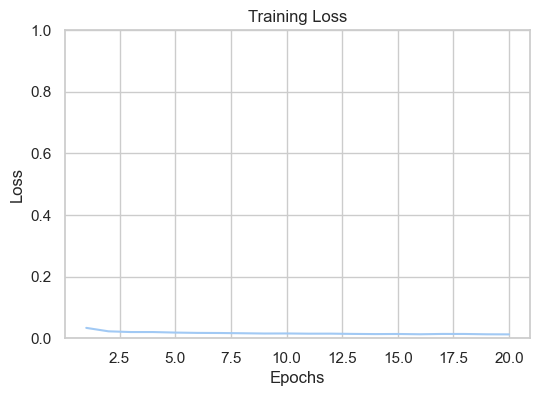

In [22]:
plot_metrics(model.train_loss, epochs=epochs, title='Loss')

Accuracy

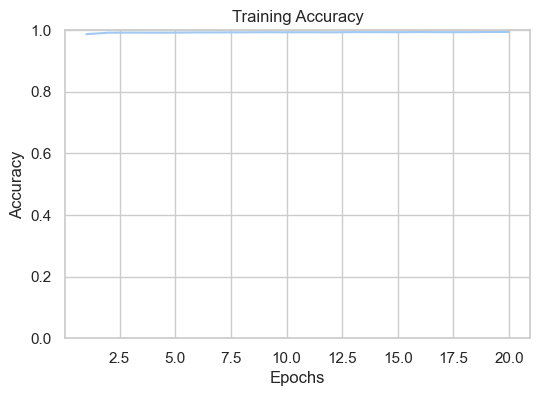

In [23]:
plot_metrics(model.train_accuracy, epochs=epochs, title='Accuracy')

F1 Macro which is the average F1 score across the epoch. This is a balance between Precision and Recall.

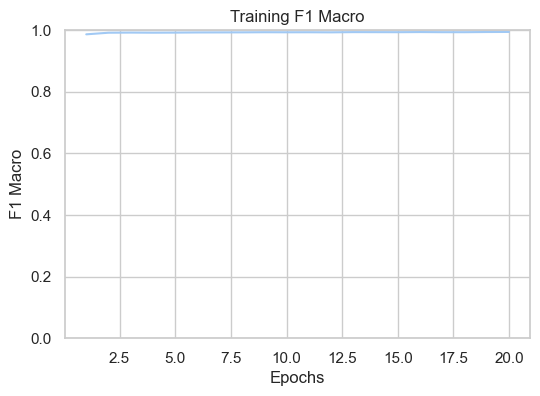

In [24]:
plot_metrics(model.train_f1, epochs=epochs, title='F1 Macro')

Epoch Time tells us on average how long each epoch took.

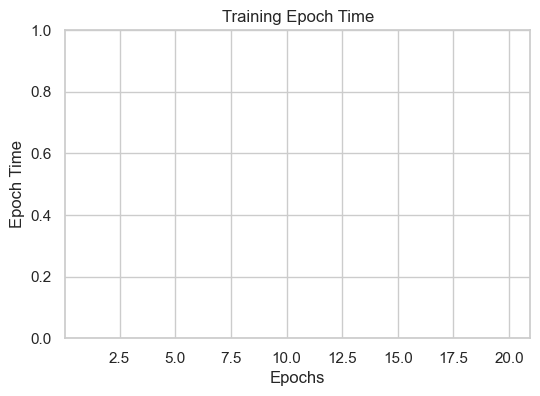

In [25]:
plot_metrics(model.epoch_time, epochs=epochs, title='Epoch Time')

In [26]:
# Run model on test set.
model.test(test_loader)

Testing: 100%|██████████| 157/157 [00:00<00:00, 327.16batch/s]

Test Loss: 0.0208, Test Accuracy: 0.9909, Test F1: 0.9910


Straight away we see that the loss is not as low as the training set meaning we potentially overfitted the model.

Most of the time we want to take it from the 'knee' at the epoch which is when the model significantly reduces decreasing loss and optimise it from there. This can be done using the load_model function and selecting the saved epoch.

In [27]:
# Check the docs for plot_confusion matrix.
help(plot_confusion_matrix)

Help on function plot_confusion_matrix in module Models.models:

plot_confusion_matrix(actual_labels, predicted_labels)
    Plot confusion matrix: Plot a confusion matrix using the results of the NNsmote class.

    Parameter:
    - actual_labels (tensor) The true labels of the data.
    - predicted_labels (tensor) The predicted labels from model.predicted_labels.



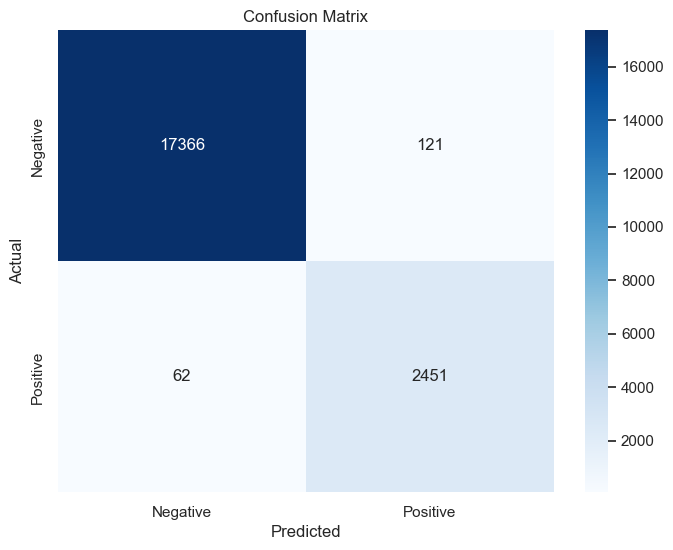

In [28]:
# So we put our actual labels and predicted labels in and get a result. Predicted labels are stored in the model.
plot_confusion_matrix(y_test, model.test_predicted)

As we can see the SMOTE sampling method focused on minority labels and only predicted 62 incorrectly but had some additional wrong predictions in the Normal labels (121). In this case SMOTE wasnt as effective as we might want it to be. Lets try reducing the learning rate and doubling the dense layer to see what happens. SMOTE tends to work better with a higher learning rate and increasing the layer size helps but only to a degree also it tends to converge much faster. It should  be kept in mind that we might want lightweight models to suit our scenario in threat detection along with the calculation of shap values.

In [32]:
device = torch.device("cpu")
n_features = X_train_tensor.shape[1]
# Increase layer size.
fc_size = 256
save_dir = './Models/saved_models/Test'
model = NNdynamic(n_features, fc_size, device, save_dir)
sampler = 'smote'
params = {'sampling_strategy': 'auto'}
# Increase learning rate.
learning_rate = 0.1
# We decrease epochs as a higher learning rate tend to converge faster.
epochs = 10
save_factor = 1
model.run(train_loader, learning_rate, epochs, save_factor, sampler, params, store_data=True)

Epoch 1/10: 100%|██████████| 625/625 [00:09<00:00, 66.54batch/s]


Epoch [1/10], Train Loss: 0.0975, Train Acc: 0.9867, Train F1: 0.9863


Epoch 2/10: 100%|██████████| 625/625 [00:11<00:00, 53.40batch/s]


Epoch [2/10], Train Loss: 0.0250, Train Acc: 0.9916, Train F1: 0.9916


Epoch 3/10: 100%|██████████| 625/625 [00:10<00:00, 57.66batch/s]


Epoch [3/10], Train Loss: 0.0230, Train Acc: 0.9924, Train F1: 0.9924


Epoch 4/10: 100%|██████████| 625/625 [00:08<00:00, 70.32batch/s]


Epoch [4/10], Train Loss: 0.0224, Train Acc: 0.9922, Train F1: 0.9922


Epoch 5/10: 100%|██████████| 625/625 [00:09<00:00, 69.10batch/s]


Epoch [5/10], Train Loss: 0.0271, Train Acc: 0.9922, Train F1: 0.9922


Epoch 6/10: 100%|██████████| 625/625 [00:09<00:00, 67.85batch/s]


Epoch [6/10], Train Loss: 0.0238, Train Acc: 0.9922, Train F1: 0.9922


Epoch 7/10: 100%|██████████| 625/625 [00:09<00:00, 67.74batch/s]


Epoch [7/10], Train Loss: 0.0227, Train Acc: 0.9924, Train F1: 0.9924


Epoch 8/10: 100%|██████████| 625/625 [00:09<00:00, 68.03batch/s]


Epoch [8/10], Train Loss: 0.0243, Train Acc: 0.9909, Train F1: 0.9909


Epoch 9/10: 100%|██████████| 625/625 [00:08<00:00, 69.92batch/s]


Epoch [9/10], Train Loss: 0.0237, Train Acc: 0.9901, Train F1: 0.9901


Epoch 10/10: 100%|██████████| 625/625 [00:08<00:00, 69.71batch/s]

Epoch [10/10], Train Loss: 0.0229, Train Acc: 0.9919, Train F1: 0.9919


Now run the model on test set and compare results.

In [33]:
model.test(test_loader)

Testing: 100%|██████████| 157/157 [00:00<00:00, 336.02batch/s]

Test Loss: 0.0258, Test Accuracy: 0.9879, Test F1: 0.9883


Ok so this is what we want. Although we have an increase in false predictions in Normal labels (243), we have successfully train a model to predict all threats (0).

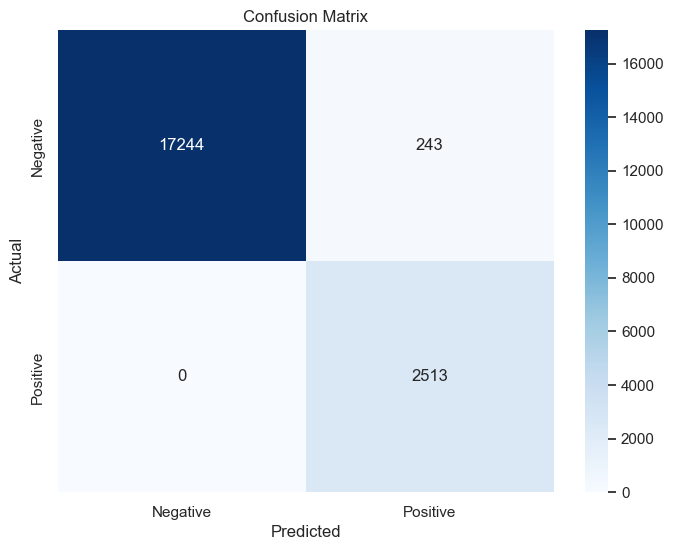

In [34]:
# Check accuracy.
plot_confusion_matrix(y_test, model.test_predicted)

Ok lets move forward into evaluating our correct predictions in threat labels through shap for the second SMOTE model. First we need to compute the background using some sample data for both labels. Then we create another dataset of the correct predictions we want to evaluate and compute the shap values.

In [35]:
# Import shap.
import shap

Here we are using the test set for evaluation purposes. We want to evaluate the predictions on the test set using the test accuracy as a baseline. If we were tuning the model using shap, we would want to use the training set. We will evaluate the SMOTE model.

In [36]:
# Create a background sample of the tensor.
idx = torch.randperm(X_test_tensor.size(0))[:1000]
background = X_test_tensor[idx]

In [37]:
# Create background.
xp = shap.DeepExplainer(model, background)

Now we need to add the labels back into our data so we can seperate correct predictions on threats then convert back into a tensor.

In [38]:
# Add the labels back in.
X_test['y_pred'] = model.test_predicted
# Then filter in this case all threat predictions are correct so we can use y_pred.
correct_threats = X_test[X_test['y_pred'] == 1]

Lets check the length before we compute shap values. If it is greater than 1000, then you might want to resample it down to 1000.

In [39]:
print(len(correct_threats))
correct_threats = correct_threats.sample(n=1000)
# After sampling drop the index to avoid calculation errors.
correct_threats = correct_threats.reset_index(drop=True)

2756


First we need to remove the predicted labels and convert to a tensor. Then we compute shap values and additionally create our explainer object for cohorts and other values.

In [40]:
# Remove labels.
correct_threats = correct_threats.drop(columns=['y_pred'])
correct_threats = torch.tensor(correct_threats.to_numpy(), dtype=torch.float32)
# We drop them from X_test as we need these for the explainer feature names.
X_test = X_test.drop(columns=['y_pred'])

In [41]:
# Compute the explainer object.
explainer = xp(correct_threats)

Now lets import the Shap class and plot some visuals.

In [42]:
from Tools.shap_manager import SHAPmanager
# read docs.
help(SHAPmanager)

Help on class SHAPmanager in module Tools.shap_manager:

class SHAPmanager(builtins.object)
 |  SHAPmanager(explainer, label_type=None, feature_encoder=None, label_encoder=None, feature_names=None, set_label=None)
 |
 |  SHAPmanager: A wrapper that handles multiple shap evaluation tasks. Automatically links the variable names to the correct shap array, handles differing parameters for
 |  visualisations, has grouping functions for ordinal and one hot encoded features, filtering of features, selecting labels, and restoring the data to the original form.
 |  Makes managing tasks easy without the large overhead of coding indexes.
 |
 |  Known Errors:
 |      - After restoring data make sure to set the label in multiclass using change_label function.
 |
 |  NOTE: This is a working progress..
 |
 |  Methods defined here:
 |
 |  __init__(self, explainer, label_type=None, feature_encoder=None, label_encoder=None, feature_names=None, set_label=None)
 |      Initiaisation: Handles different typ

The SHAP manager class works the same for binary tree models and Neural Network Models. When creating the class set the label type to binary. If a set_label option is not given it will default to the positive label (1) which in our case is threats. The label can be switched but there is not much purpose for binary shap visuals since they will just show the inverse. The following sections show some examples of how the binary version of the SHAP manager class can be utilised.

In [43]:
# The explainer object used is the full explainer which includes the shap values and dataframe (converted to a pd.DataFrame in initiliasation).
# When using torch tensors the feature names need to be provided and will be automatically set for the visualisations.
feature_names = X_test.columns
# label type is set to binary and the label is set to 1 by default. set_label can be provided to specify either 'Threat' or 'Normal' labels but it is somewhat redundant.
label_type = 'binary'
# Feature encoders only need to be provided if using the tree version and wanting to plot with string names or use the custom_group function.
# (this is provided in the multi-class example).
sm = SHAPmanager(explainer, label_type=label_type, feature_names=feature_names)

Lets view a summary plot for the NN model.

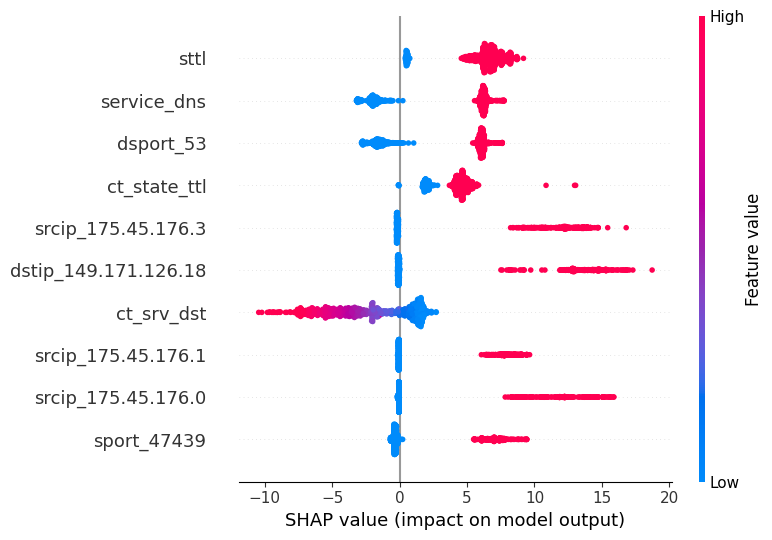

In [44]:
sm.plot_summary(max_features=10)

We can also provide a specific list of features for the summary plot.

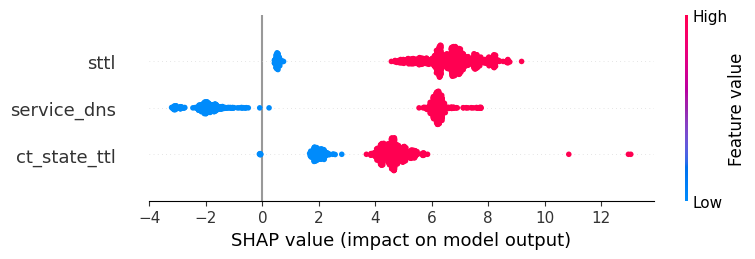

In [46]:
features = ['ct_state_ttl', 'service_dns', 'sttl']
sm.plot_summary(features=features)

We might be interested in removing some features such as IP addresses.

In [47]:
ips = []
for i in sm.explainer.data.columns:
    if i.startswith('srcip_') or i.startswith('dstip_'):
        ips.append(i)
sm.remove_features(ips)

Now lets view the summary plot again.

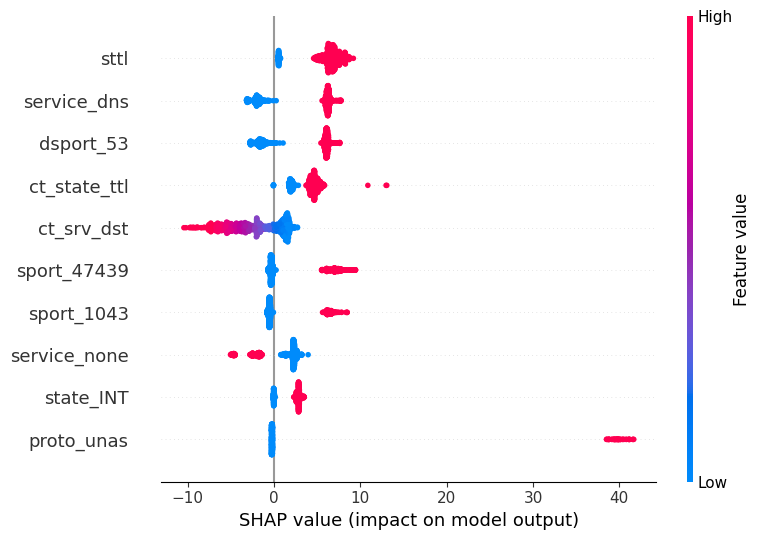

In [48]:
sm.plot_summary(max_features=10)

The data can be easily restored to the original.

In [49]:
sm.restore_data()

Lets view a dependence plot for proto_tcp, one of the one-hot encoded variables.

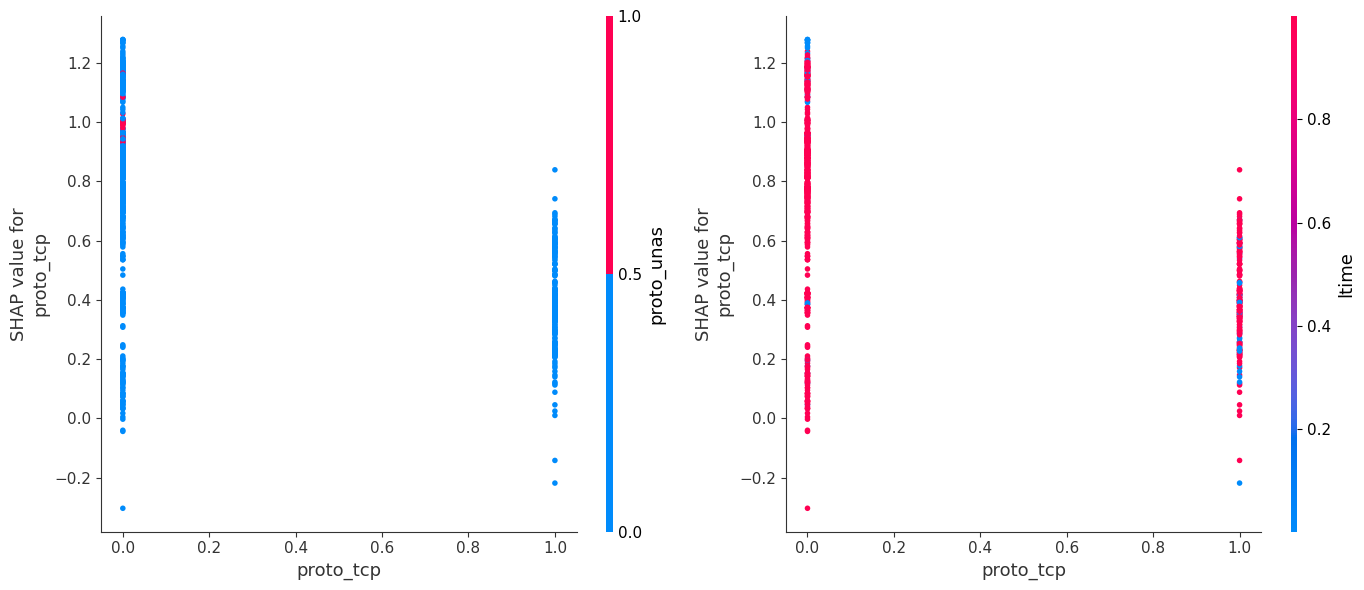

In [50]:
# Here we set the amount of interactions we want to view which are given with the approximate interaction function to find the strongest interactions.
n_interaction = 2
sm.plot_dependence('proto_tcp', n_interaction=n_interaction)

We might be interested in viewing the proto one hot encoded variables as a set. To do this we can use the stacked_group function which stacks all the one hot encoded features into a single group and also converts the other shap values and data to suit. The values are calculated using the absolute average shap values and filtered to a limit. This allows the features that potentially have shap values of 0 to be filtered.

In [51]:
# The maximum number of features to group sorted by highest absolute average shap value.
limit = 30
# The type of calculation. It is recommended to use average.
calculation = 'average'
sm.stacked_group('proto', limit=limit, calculation=calculation)

Now lets re-plot the dependency plot for the variable. The variable name has changed to just proto now.

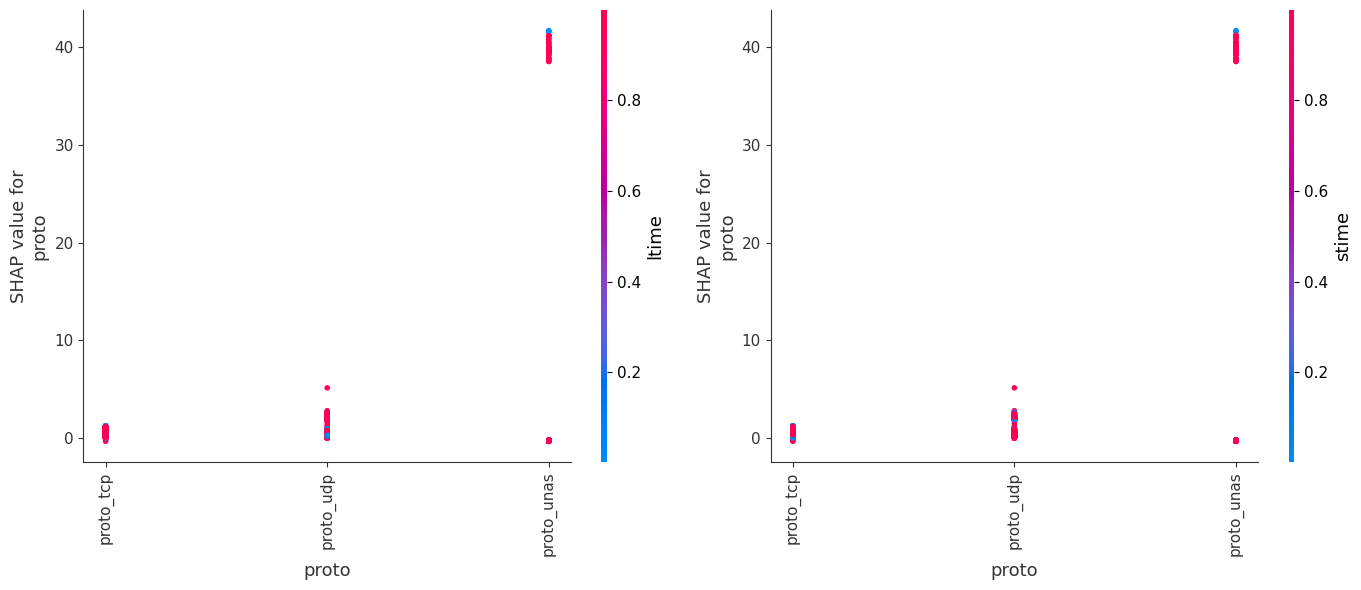

In [52]:
n_interaction = 2
sm.plot_dependence('proto', n_interaction=n_interaction)

It is important to restore the data after stacking and viewing the visualisations.

In [53]:
sm.restore_data()

Lets view one more categorical feature.

In [54]:
# The maximum number of features to group sorted by highest absolute average shap value.
limit = 30
# The type of calculation. It is recommended to use average.
calculation = 'average'
sm.stacked_group('state', limit=limit, calculation=calculation)

We can also add custom colours to the plot. This is particularly useful for the interaction index when using categorical features. Lets use state as the interaction index. We can also use the jitter and alpha function to make it more interpretable.

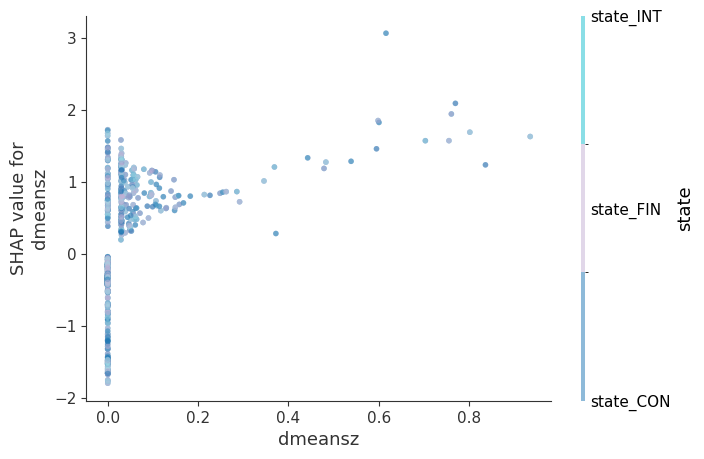

In [55]:
# Here we set state as the specific interaction.
specific_interaction = 'state'
sm.plot_dependence('dmeansz', specific_interaction=specific_interaction, colour='tab20', alpha=0.5, x_jitter=1)